Importing Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # !pip install tensorflow
# import numpy as np
# import pickle
# import cv2
# import os
# import matplotlib.pyplot as plt
# from os import listdir
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import load_img
# from keras.preprocessing import image
# # from keras.preprocessing.image import img_to_array
# from tensorflow.keras.utils import img_to_array
# from sklearn.model_selection import train_test_split
# from numpy import expand_dims
# import pandas as pd
# import random

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
data ='/content/drive/MyDrive/archive(6)/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'

Number of unique plants

In [ ]:
val_dir= os.path.join(data, 'valid')
train_dir = os.path.join(data, 'train') #root_dir +{'train'}

unique_plants = []
cl = os.listdir(train_dir)
for i in cl:
    x = i.split('_')
    if x[0] not in unique_plants:
        unique_plants.append(x[0])
print("Number of Unique Plants: ",len(unique_plants))
print("Unique Plants: ",unique_plants)

Number of Unique Plants:  5
Unique Plants:  ['Apple', 'Grape', 'Cherry', 'Peach', 'Strawberry']


In [ ]:
diseases = os.listdir(train_dir)
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Apple___Black_rot                                    1987
Apple___Apple_scab                                   2016
Apple___Cedar_apple_rust                             1760
Apple___healthy                                      2008
Grape___Black_rot                                    1888
Cherry_(including_sour)___Powdery_mildew             1683
Cherry_(including_sour)___healthy                    1826
Grape___healthy                                      1692
Grape___Esca_(Black_Measles)                         1920
Peach___healthy                                      1728
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)           1722
Peach___Bacterial_spot                               1838
Strawberry___Leaf_scorch                             1774
Strawberry___healthy                                 1824

Text(0.5, 1.0, 'Images per each class of plant disease')

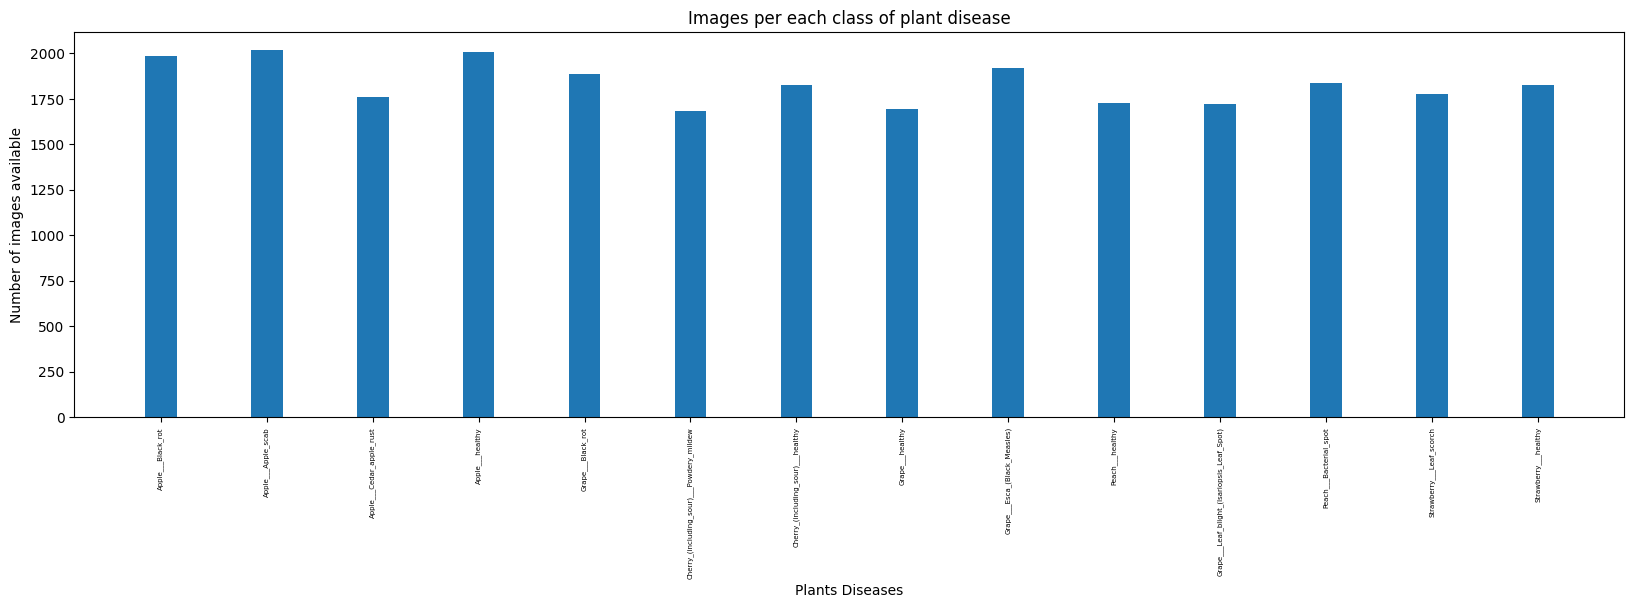

In [ ]:
index = [n for n in range(14)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants Diseases', fontsize=10)
plt.ylabel('Number of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

Found 25666 images belonging to 14 classes.


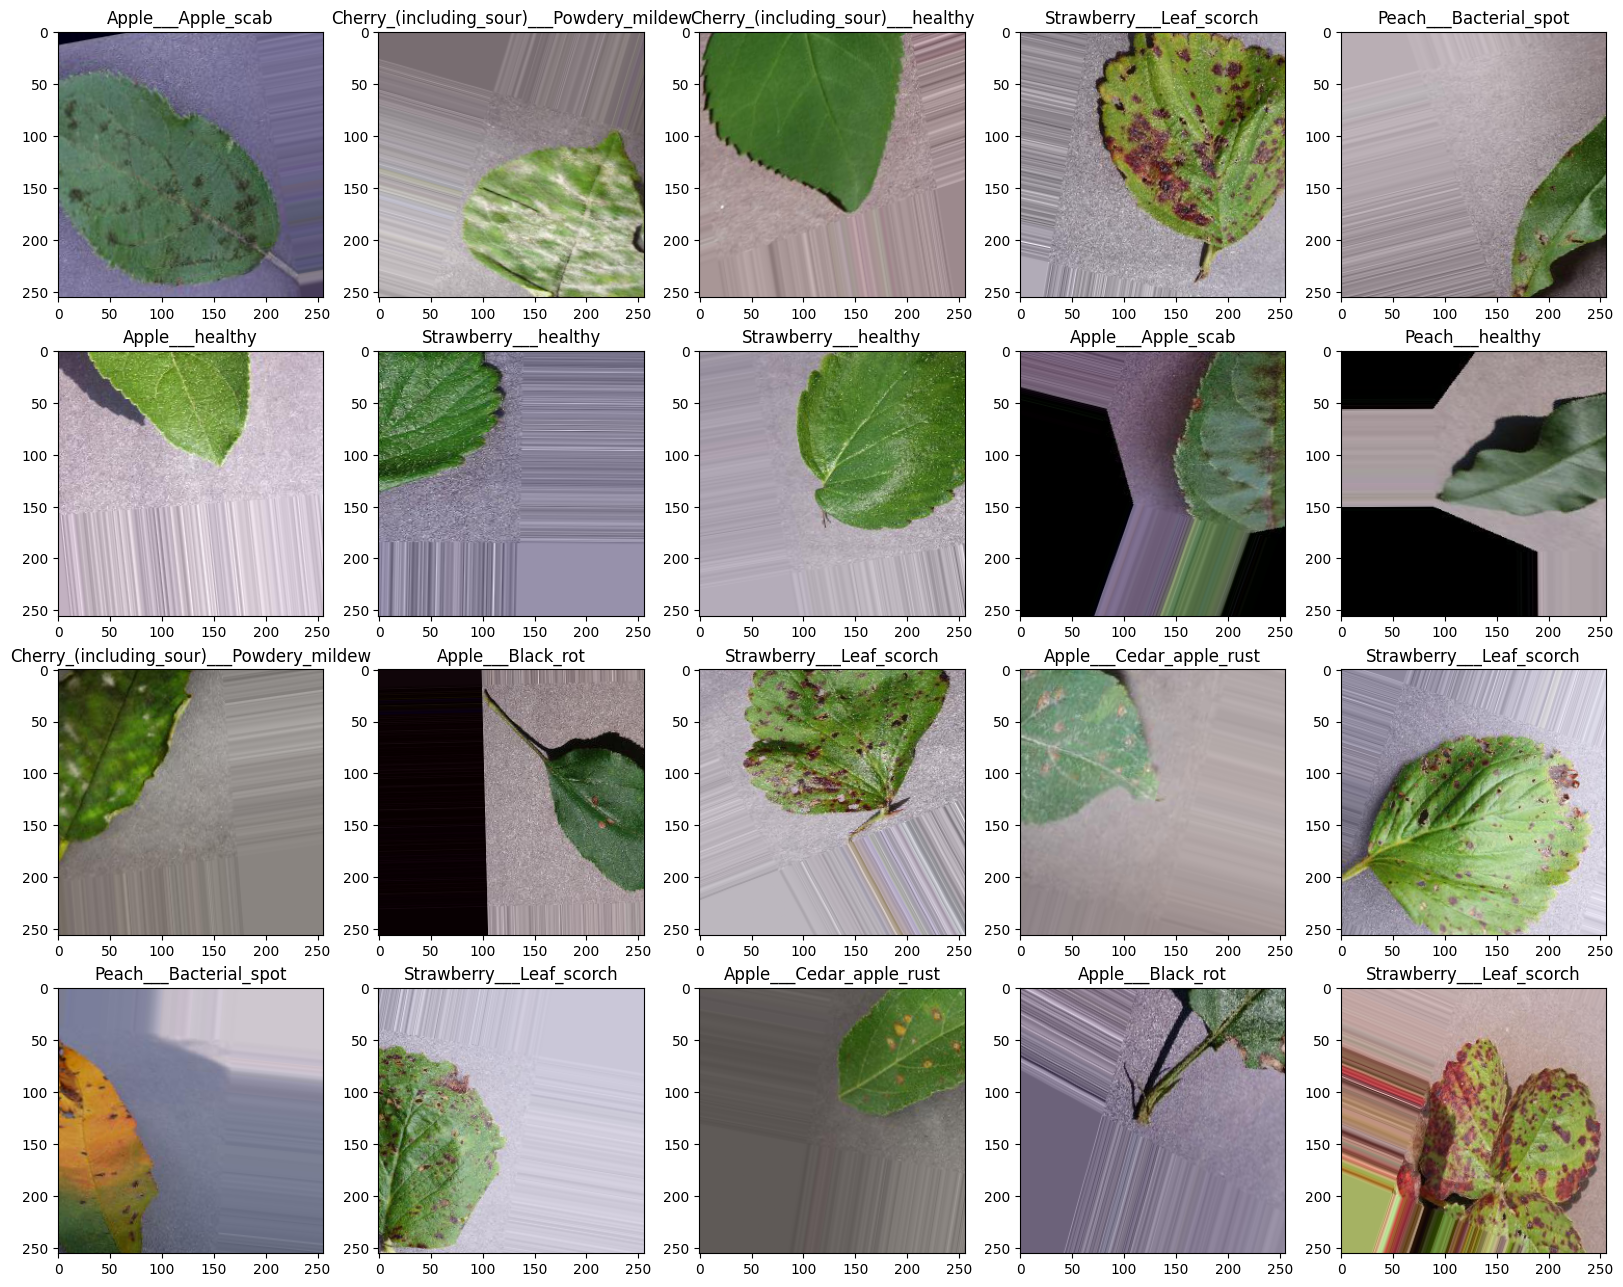

In [ ]:
train_datagen= ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1/255.0,
    fill_mode='nearest',
    validation_split=0.1)
train_dir= train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(256,256),color_mode='rgb',class_mode='categorical',seed=42)
classes=list(train_dir.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_dir:
    for i in range(0,20):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    plt.show()
    break

Loading Training and Test Dataset as Tensor

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(size = 224),
     transforms.ToTensor()])

In [ ]:
dataset = ImageFolder(train_dir,transform=transform)
test_ds = ImageFolder(val_dir,transform=transform)

In [ ]:
print("Number of training images: ",len(dataset))
print("Number of testing images: ",len(test_ds))

Number of training images:  25666
Number of testing images:  6026


Number of classes

In [ ]:
num_classes = dataset.classes
print("Number of classes: ",len(num_classes))
print(num_classes)

Number of classes:  14
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy']


Visualising a single image

In [ ]:
image, label  = dataset[0]
print("Image shape:",image.shape)
print("Image Label: ",label)
print("Image Label: ",dataset.classes[label])
print(image)

Image shape: torch.Size([3, 224, 224])
Image Label:  0
Image Label:  Apple___Apple_scab
tensor([[[0.6588, 0.6549, 0.6510,  ..., 0.7294, 0.7216, 0.7098],
         [0.6667, 0.6627, 0.6588,  ..., 0.7333, 0.7294, 0.7216],
         [0.6627, 0.6627, 0.6588,  ..., 0.7373, 0.7333, 0.7294],
         ...,
         [0.3961, 0.4039, 0.4078,  ..., 0.5020, 0.4980, 0.4980],
         [0.3961, 0.4000, 0.4039,  ..., 0.4824, 0.4863, 0.4863],
         [0.4039, 0.4039, 0.4000,  ..., 0.4706, 0.4784, 0.4824]],

        [[0.6431, 0.6392, 0.6353,  ..., 0.7176, 0.7098, 0.6980],
         [0.6510, 0.6471, 0.6431,  ..., 0.7216, 0.7176, 0.7098],
         [0.6471, 0.6471, 0.6431,  ..., 0.7255, 0.7216, 0.7176],
         ...,
         [0.3569, 0.3647, 0.3686,  ..., 0.4392, 0.4353, 0.4353],
         [0.3569, 0.3608, 0.3647,  ..., 0.4196, 0.4235, 0.4235],
         [0.3647, 0.3647, 0.3608,  ..., 0.4078, 0.4157, 0.4196]],

        [[0.7725, 0.7686, 0.7647,  ..., 0.8314, 0.8235, 0.8118],
         [0.7804, 0.7765, 0.7725,  

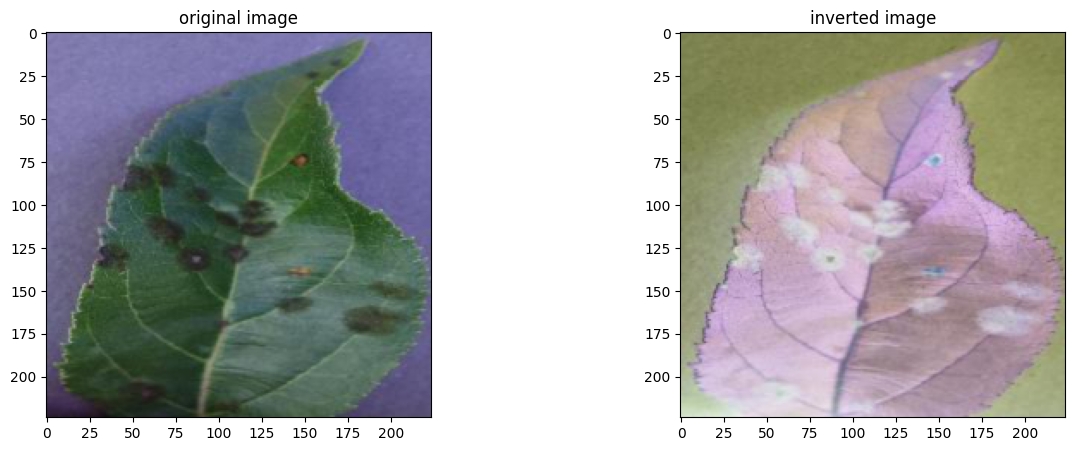

In [ ]:
image, label  = dataset[1]
fig,(ax1,ax2) = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
ax1.imshow(image.permute(1,2,0))
ax1.set_title("original image")
ax2.imshow(1-image.permute(1,2,0))
ax2.set_title("inverted image")
plt.show()

Validation Dataset and Dataloader

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
validation_split = 0.3
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [ ]:
batch_size = 64

train_loader = DataLoader(train_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)

Visualising a Batch of images

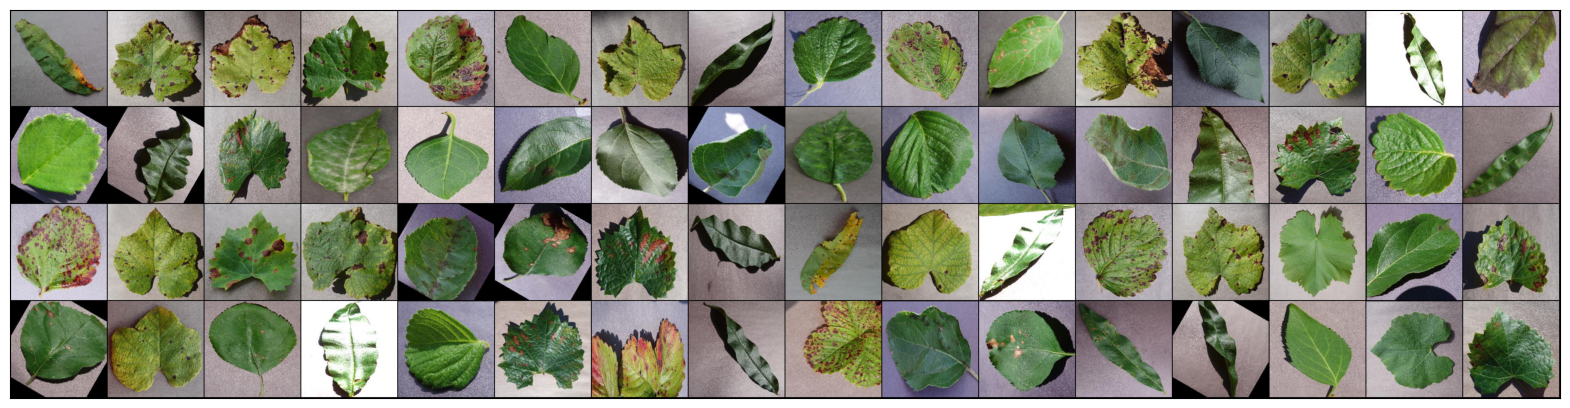

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

Building a CNN model

In [ ]:
class Plant_Disease_Model1(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.AdaptiveAvgPool2d(1),

        nn.Flatten(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,38)
        )

  def forward(self,xb):
    out = self.network(xb)
    return out

VGG16

In [ ]:
class Plant_Disease_Model2(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = models.vgg16(pretrained=True)
    num_ftrs = self.network.classifier[-1].in_features
    self.network.classifier[-1] = nn.Linear(num_ftrs, 38)

  def forward(self,xb):
    out = self.network(xb)
    return out

ResNet34

In [ ]:
class Plant_Disease_Model3(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = models.resnet34(pretrained=True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 38)

  def forward(self,xb):
    out = self.network(xb)
    return out

ResNet50

In [ ]:
class Plant_Disease_Model4(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = models.resnet50(pretrained=True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 38)

  def forward(self,xb):
    out = self.network(xb)
    return out

Train/Evaluate

In [ ]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
model = to_device(Plant_Disease_Model1(), device)

In [ ]:
model

Plant_Disease_Model1(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(256, 512, kernel_size=(3, 3), stri

Training the model

In [ ]:
evaluate(model,val_loader)

{'val_loss': 3.635209321975708, 'val_acc': 0.0}

Training the model

In [ ]:
history = fit(10, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

NameError: ignored

In [ ]:
history += fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0293, val_loss: 0.0808, val_acc: 0.9739


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0264, val_loss: 0.0223, val_acc: 0.9924


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0150, val_loss: 0.0461, val_acc: 0.9894


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0129, val_loss: 0.0173, val_acc: 0.9956


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0072, val_loss: 0.0311, val_acc: 0.9912


Plotting accuracy and losses

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-gx')
    plt.plot(val_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

NameError: ignored

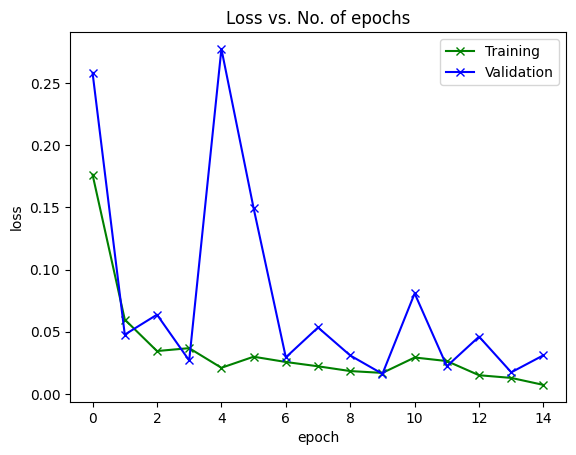

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model,val_loader)

{'val_loss': 0.031060244888067245, 'val_acc': 0.9912189841270447}

In [ ]:
x = evaluate(model,test_loader)
x

{'val_loss': 0.031285423785448074, 'val_acc': 0.9911184310913086}

Prediction on some single image of test data

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: Apple___Apple_scab , Predicted: Apple___Apple_scab


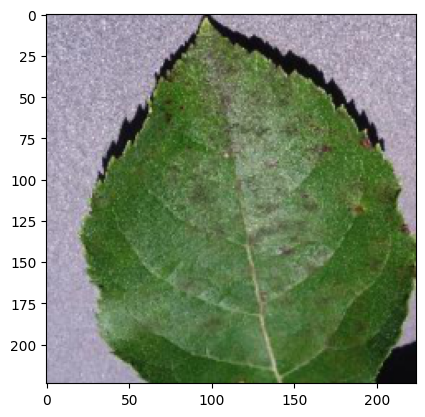

In [ ]:
img, label = test_ds[29]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple___Black_rot , Predicted: Apple___Black_rot


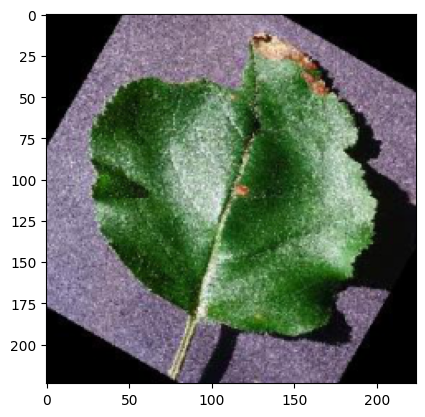

In [ ]:
img, label = test_ds[979]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Cherry_(including_sour)___healthy , Predicted: Cherry_(including_sour)___healthy


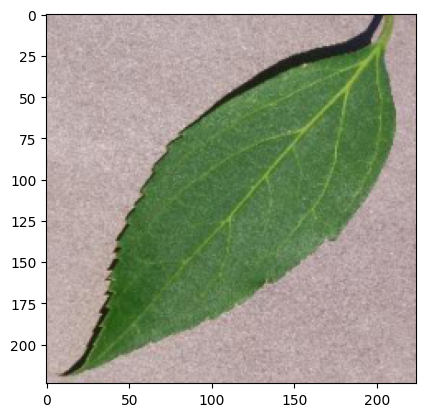

In [ ]:
img, label = test_ds[2448]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
torch.save(model.state_dict(), 'plantDisease-vgg16.pth')

In [ ]:
PATH = "Plant_Disease.pt"

# Save
torch.save(model, PATH)
# Load
# model = torch.load(PATH)
# model.eval()